In [1]:
import numpy as np 
import pandas as pd 
import pyreadstat

In [2]:
# reading the states file
fp3 = "./states and ut/3_LASI_W1_Individual_v4.sav"
df_fp3, meta_fp3 = pyreadstat.read_sav(fp3, encoding="latin1")

In [3]:
# Function to get the variable name given a column label (case-insensitive)
def get_varname_by_label(meta, target_label):
    target_label = target_label.strip().lower()
    for var, label in meta.column_names_to_labels.items():
        if label is not None and label.strip().lower() == target_label:
            return var
    return None

# Define a function to recode yes/no responses (assuming 1=Yes, 2=No)
def recode_yes(x):
    return 1 if x == 1 else 0  # Convert 1 to 1, everything else to 0

# Defining Migration
---

| **Variable**     | **Type**      | **Coding / Description**                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
|------------------|---------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **migration_1**  | Categorical   | **Life‐course Migration Indicator** derived from comparing the respondent’s full place‐of‐birth location with their life‐course residential history. The full location is a concatenated string of country, state, district, and village/town.<br><br>• **0**: No migration – if the respondent’s childhood and adult residences match their place of birth or if the “years living continuously in this area” value equals 9993 (indicating “since birth”).<br>• **1**: Childhood migration – if any component of the childhood residence (up to age 14) differs from the place of birth.<br>• **2**: Adult migration – if no childhood migration is detected but any component of the adult residence (most of your adult life) differs from the place of birth. |
| **migration_2**  | Binary        | **Hard Threshold Indicator** based on the duration of residence in the current area.<br><br>• **1**: Migrant – if the respondent has lived in the current area for less than 20 years.<br>• **0**: Non‐migrant – if the respondent has lived in the current area for 20 years or more or if the “years living continuously” value equals 9993 (i.e. “since birth”).                                                     |
| **migration_3**  | Ordinal       | **Duration-Based Migration Indicator** using the number of years of continuous residence in the current area. The categories are defined as follows:<br><br>• **1**: 0–2 years<br>• **2**: 3–5 years<br>• **3**: 6–10 years<br>• **4**: 11–20 years<br>• **5**: 21–40 years<br>• **6**: More than 40 years<br>• **0**: Missing or undefined values                                                     |
| **migration_4**  | Categorical   | **Rural/Urban Migration Type** derived from comparing the rural/urban classification of the respondent’s place of birth with that of their last residence.<br><br>• **1**: Rural-to-Rural<br>• **2**: Rural-to-Urban<br>• **3**: Urban-to-Rural<br>• **4**: Urban-to-Urban<br>• **0**: Missing or undefined (if either classification is missing)                                               |

---



In [4]:
# params for definition 2
THRESHOLD = 20

# params for definition 3
BINS = [-np.inf, 2, 5, 10, 20, 40, np.inf]
LABELS = [1, 2, 3, 4, 5, 6]

# params for outcome - mental health (CIDI SF score method)
# Define the column names directly (based on the lowercase version of LASI dataset codes)
cols_cidi1 = ["mh204", "mh205", "mh206", "mh207", "mh208", "mh209", "mh210", "mh211"]
cols_cidi2 = ["mh217", "mh218", "mh219", "mh220", "mh221", "mh222"]

# Screening questions
col_MH201 = "mh201"  # Screening for dysphoria
col_MH214 = "mh214"  # Screening for anhedonia

CIDI_1_THRESHOLD = 3 # Depression: if CIDI_1 score >=3, then 1 else 0

In [5]:
# Get variable name for "Since how many years living continuously in this area"
col_name_years = get_varname_by_label(meta_fp3, "Since how many years living continuously in this area")
if col_name_years is None:
    raise ValueError("Column label 'Since how many years living continuously in this area' not found in fp3.sav metadata.")

# Convert the column to numeric (handling errors)
years_living = pd.to_numeric(df_fp3[col_name_years], errors='coerce')

# Create a new DataFrame for migration_2 and migration_3
df_input = pd.DataFrame()


In [6]:

# Retrieve variable names for place of birth
col_birth_country = get_varname_by_label(meta_fp3, "Place of birth-country")
col_birth_state   = get_varname_by_label(meta_fp3, "Place of birth-state")
col_birth_district = get_varname_by_label(meta_fp3, "Place of birth-district")
col_birth_village  = get_varname_by_label(meta_fp3, "Place of birth-village/town")

# Retrieve variable names for childhood residence
col_child_country = get_varname_by_label(meta_fp3, "Lived most of your childhood-Country")
col_child_district = get_varname_by_label(meta_fp3, "Lived most of your childhood-distirct")
col_child_state   = get_varname_by_label(meta_fp3, "Lived most of your childhood-state")
col_child_village  = get_varname_by_label(meta_fp3, "Lived most of your childhood-village/town")

# Retrieve variable names for adult residence
col_adult_country = get_varname_by_label(meta_fp3, "Lived most of your adult life-country")
col_adult_state   = get_varname_by_label(meta_fp3, "Lived most of your adult life-state")
col_adult_district = get_varname_by_label(meta_fp3, "Lived most of your adult life-district")
col_adult_village  = get_varname_by_label(meta_fp3, "Lived most of your adult life-village/town")

# Check that all required variables were found
for name, col in [("Place of birth-country", col_birth_country),
                  ("Place of birth-state", col_birth_state),
                  ("Place of birth-district", col_birth_district),
                  ("Place of birth-village/town", col_birth_village),
                  ("Lived most of your childhood-Country", col_child_country),
                  ("Lived most of your childhood-distirct", col_child_district),
                  ("Lived most of your childhood-state", col_child_state),
                  ("Lived most of your childhood-village/town", col_child_village),
                  ("Lived most of your adult life-country", col_adult_country),
                  ("Lived most of your adult life-state", col_adult_state),
                  ("Lived most of your adult life-district", col_adult_district),
                  ("Lived most of your adult life-village/town", col_adult_village)]:
    if col is None:
        raise ValueError(f"Column label '{name}' not found in fp3.sav metadata.")

# Extract the relevant columns and clean the data
def clean_series(series):
    return series.astype(str).str.strip().str.lower().fillna("")

birth_country = clean_series(df_fp3[col_birth_country])
birth_state = clean_series(df_fp3[col_birth_state])
birth_district = clean_series(df_fp3[col_birth_district])
birth_village = clean_series(df_fp3[col_birth_village])

child_country = clean_series(df_fp3[col_child_country])
child_state = clean_series(df_fp3[col_child_state])
child_district = clean_series(df_fp3[col_child_district])
child_village = clean_series(df_fp3[col_child_village])

adult_country = clean_series(df_fp3[col_adult_country])
adult_state = clean_series(df_fp3[col_adult_state])
adult_district = clean_series(df_fp3[col_adult_district])
adult_village = clean_series(df_fp3[col_adult_village])

# Create concatenated location strings (using a separator to clearly mark boundaries)
birth_location = birth_country + "|" + birth_state + "|" + birth_district + "|" + birth_village
child_location = child_country + "|" + child_state + "|" + child_district + "|" + child_village
adult_location = adult_country + "|" + adult_state + "|" + adult_district + "|" + adult_village

# Compute migration indicators:
# Childhood Migration Indicator: 1 if any level differs between place of birth and childhood residence, else 0.
child_migration = (birth_location != child_location).astype(int)

# Adult Migration Indicator: 1 if any level differs between place of birth and adult residence, else 0.
adult_migration = (birth_location != adult_location).astype(int)

# Create a new DataFrame with the concatenated locations and migration indicators
df_life_course_migration = pd.DataFrame({
    "Birth Location": birth_location,
    "Childhood Location": child_location,
    "Childhood Migration Indicator": child_migration,
    "Adult Location": adult_location,
    "Adult Migration Indicator": adult_migration
})

# df_input["migration_1"] = np.where(
#     years_living == 9993,
#     "0",
#     np.where(child_migration == 1, "child_migration",
#              np.where(adult_migration == 1, "adult_migration", "0"))
# )

df_input["migration_1"] = np.where(
    years_living == 9993,
    "0",
    np.where(child_migration == 1, 1,
             np.where(adult_migration == 1, 2, 0))
)



# Create migration_2: 0 if years >= THRESHOLD, else 1
df_input["migration_2"] = np.where(years_living >= THRESHOLD, 0, 1)

# Use pd.cut, and fill NaN values with a default category (e.g., 0 for unknown)
df_input["migration_3"] = pd.cut(years_living, bins=BINS, labels=LABELS, right=True)

# Convert migration_3 to integer, replacing NaN with 0 (or any default category you prefer)
df_input["migration_3"] = df_input["migration_3"].cat.add_categories(0).fillna(0).astype(int)



In [ ]:
# Get variable names by column labels (using your previously defined function)
col_DM017 = get_varname_by_label(meta_fp3, "Place of residence")
col_DM018 = get_varname_by_label(meta_fp3, "Place of last residence-village/town")

# Extract the columns for DM017 and DM018
# (These variables are assumed to contain numeric codes: 1 for village, 2 for town)
place_birth = df_fp3[col_DM017]
place_last_res = df_fp3[col_DM018]
place_curr_res=df_fp3[get_varname_by_label(meta_fp3, "Place of residence")]

# For clarity, create a new DataFrame with only the two variables:
df_migration_type = pd.DataFrame({
    "Place of Birth": place_birth,
    "Place of Last Residence": place_last_res,
    "Place of residence" : place_curr_res
})

# Define a function to classify migration type based on rural/urban codes
# def classify_migration(row):
#     pb = row["Place of Birth"]
#     plr = row["Place of Last Residence"]
#     # Check for missing values (if not coded as 1 or 2, you might want to handle them separately)
#     if pd.isna(pb) or pd.isna(plr):
#         return "0"
#     if pb == 1 and plr == 1:
#         return "Rural-to-Rural"
#     elif pb == 1 and plr == 2:
#         return "Rural-to-Urban"
#     elif pb == 2 and plr == 1:
#         return "Urban-to-Rural"
#     elif pb == 2 and plr == 2:
#         return "Urban-to-Urban"
#     else:
#         return np.nan

def classify_migration(row):
    pb = row["Place of Birth"]
    plr = row["Place of Last Residence"]
    pr=row["Place of residence"]
    
    # Check for missing values (if not coded as 1 or 2, you might want to handle them separately)
    if pd.isna(pb) or pd.isna(plr):
        return 0
    if pr == 1 and plr == 1:
        return 1
    elif pr == 1 and plr == 2:
        return 2
    elif pr == 2 and plr == 1:
        return 3
    elif pr == 2 and plr == 2:
        return 4
    else:
        return np.nan

# Apply the function to each row to create a new column 'Migration Type'
df_input["migration_4"] = df_migration_type.apply(classify_migration, axis=1)

In [8]:
# Compute CIDI_1 (dysphoria score)
df_fp3["MH201_binary"] = df_fp3[col_MH201].apply(recode_yes)
df_input["CIDI_1"] = df_fp3[cols_cidi1].applymap(recode_yes).sum(axis=1)
df_input.loc[df_fp3["MH201_binary"] == 0, "CIDI_1"] = 0  # Set to 0 if screening was No

# Compute CIDI_2 (anhedonia score)
df_fp3["MH214_binary"] = df_fp3[col_MH214].apply(recode_yes)
df_input["CIDI_2"] = df_fp3[cols_cidi2].applymap(recode_yes).sum(axis=1)
df_input.loc[df_fp3["MH214_binary"] == 0, "CIDI_2"] = 0  # Set to 0 if screening was No

# Create binary depression variable (1 if CIDI_1 >= CIDI_1_THRESHOLD, else 0)
df_input["depression"] = df_input["CIDI_1"].apply(lambda x: 1 if x >= CIDI_1_THRESHOLD else 0)


In [9]:
print(df_input.head())

  migration_1  migration_2  migration_3  migration_4  CIDI_1  CIDI_2  \
0           0            0            6            0       0       0   
1           0            0            6            0       0       0   
2           0            0            5            1       0       0   
3           0            0            6            0       0       0   
4           0            0            6            1       0       0   

   depression  
0           0  
1           0  
2           0  
3           0  
4           0  


# Controlling Variables

In [10]:


# --- 1. Education ---
# Column codes (in lowercase) are used directly.
# dm006: Ever attended school
# dm008: Highest level of education
# Rule:
#   - If dm006 != 1, education = 0.
#   - Otherwise, if dm008 is 1,2,3,or 4, education = that value.
#     If dm008 is 5,6,7,8, or 9, education = 5.
def compute_education(row):
    try:
        attended = int(row["dm006"])
    except:
        attended = 0
    if attended != 1:
        return 0
    try:
        edu = int(row["dm008"])
    except:
        return 0
    if edu in [1, 2, 3, 4]:
        return edu
    elif edu in [5, 6, 7, 8, 9]:
        return 5
    else:
        return 0

df_input["education_level"] = df_fp3.apply(compute_education, axis=1).fillna(0)

# --- 2. Living Arrangements ---
# fs329: Are you satisfied with your current living arrangements?
# Original coding: 1 = Strongly satisfied, 2 = Satisfied, 3 = Neither, 4 = Dissatisfied, 5 = Strongly dissatisfied.
# We want: 1 = Strongly dissatisfied, 5 = Strongly satisfied.
# Compute new value as: new_value = 6 - original_value.
def compute_living(val):
    try:
        v = int(val)
    except:
        return 0
    if v in [1, 2, 3, 4, 5]:
        return 6 - v
    else:
        return 0

df_input["living_arrangements"] = df_fp3["fs329"].apply(compute_living).fillna(0)

# --- 3. MPCE Quintile ---
# We assume the column name is exactly "mpce quintile" (in lowercase)
col_mpce = get_varname_by_label(meta_fp3, "MPCE quintile")
df_input["mpce_quintile"] = df_fp3[col_mpce].fillna(0).astype(int)

# --- 4. Age Category ---
# dm005: Age at last birthday (in complete years)
# Create categories:
#   45-55 -> 1, 55-65 -> 2, 65-75 -> 3, 75-85 -> 4, >85 -> 5.
df_fp3["age_numeric"] = pd.to_numeric(df_fp3["dm005"], errors="coerce").fillna(0)
bins = [45, 55, 65, 75, 85, np.inf]
labels = [1, 2, 3, 4, 5]
df_fp3["age_category"] = pd.cut(df_fp3["age_numeric"], bins=bins, labels=labels, right=False)
# Replace missing age category with 0 and convert to integer
df_input["age_category"] = df_fp3["age_category"].cat.add_categories(0).fillna(0).astype(int)

# --- 5. Currently Working ---
# we004: Are you currently working? (Assumed coding: 1 = Yes, otherwise No)
# df_fp3["currently_working"] = df_fp3["we004"].apply(lambda x: 1 if str(x).strip() == "1" else 0).fillna(-1)

# --- Create New DataFrame ---
# Select only the new columns we need.
# df_new = df_[["education", "living_arrangements", "mpce_quintile", "age_category"]]

# Display the first few rows of the new DataFrame
print(df_input.head())


  migration_1  migration_2  migration_3  migration_4  CIDI_1  CIDI_2  \
0           0            0            6            0       0       0   
1           0            0            6            0       0       0   
2           0            0            5            1       0       0   
3           0            0            6            0       0       0   
4           0            0            6            1       0       0   

   depression  education_level  living_arrangements  mpce_quintile  \
0           0                0                    2              4   
1           0                0                    2              4   
2           0                0                    4              4   
3           0                5                    4              4   
4           0                0                    5              4   

   age_category  
0             3  
1             3  
2             1  
3             1  
4             5  


In [11]:
counts = df_input["migration_1"].value_counts()
print(counts)
print()
counts = df_input["migration_2"].value_counts()
print(counts)
print()
counts = df_input["migration_3"].value_counts()
print(counts)
print()
counts = df_input["migration_4"].value_counts()
print(counts)
print()
counts = df_input["depression"].value_counts()
print(counts)
print()
counts = df_input["education_level"].value_counts()
print(counts)
print()
counts = df_input["living_arrangements"].value_counts()
print(counts)
print()
counts = df_input["mpce_quintile"].value_counts()
print(counts)
print()
counts = df_input["age_category"].value_counts()
print(counts)
print()


migration_1
0    58997
2    12183
1     2216
Name: count, dtype: int64

migration_2
0    65063
1     8333
Name: count, dtype: int64

migration_3
6    44541
5    18759
4     5848
3     2040
2     1120
1      964
0      124
Name: count, dtype: int64

migration_4
0    31085
1    23834
3    10830
4     6339
2     1308
Name: count, dtype: int64

depression
0    68999
1     4397
Name: count, dtype: int64

education_level
0    33762
2     9849
1     8188
5     7452
3     7345
4     6800
Name: count, dtype: int64

living_arrangements
4    41893
5    15618
3    11363
2     2540
0     1529
1      453
Name: count, dtype: int64

mpce_quintile
4    14908
3    14764
2    14757
5    14545
1    14422
Name: count, dtype: int64

age_category
1    24537
2    20434
3    14755
0     6790
4     5412
5     1468
Name: count, dtype: int64



In [12]:
df_input.to_csv('df_input_states.csv', index=False)


In [13]:
# Get the variable name for "Sex of Respondent"
col_sex = get_varname_by_label(meta_fp3, "Sex of Respondent")

# Check result (should be "dm003")
print("Sex column variable name:", col_sex)

# Map to readable labels (optional)
sex_map = {1: "Male", 2: "Female"}

# Add to df_input
df_input["sex"] = df_fp3[col_sex].map(sex_map).fillna("Unknown")
print(df_input["sex"].unique())

Sex column variable name: dm003
['Female' 'Male']


In [ ]:
# Get the variable name for "Sex of Respondent"
place = get_varname_by_label(meta_fp3, "Place of residence")

# Check result (should be "dm003")
print(df_fp3[place].unique())

[1. 2.]


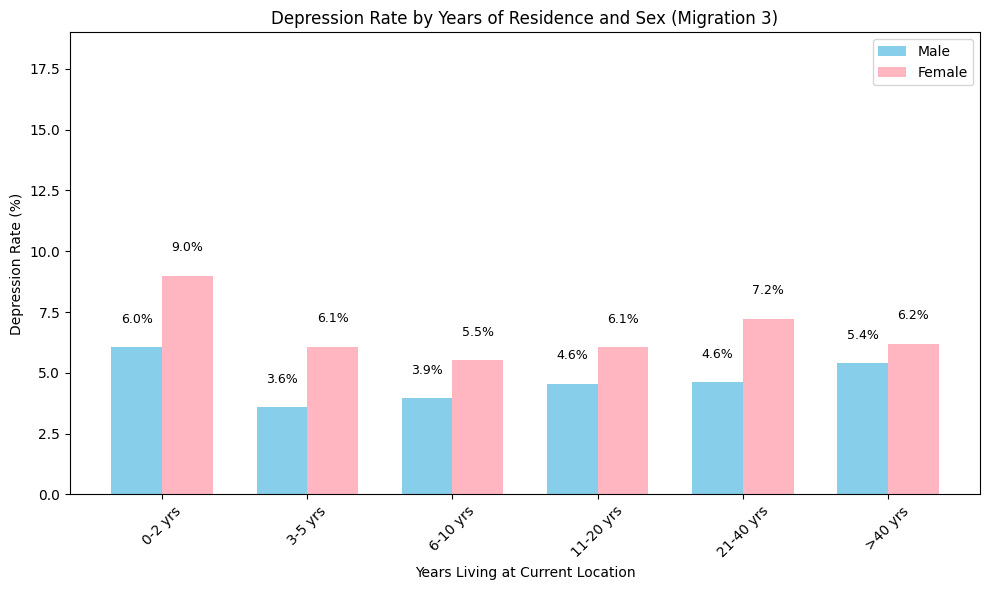

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter only valid migration_3 values
valid_classes = [1, 2, 3, 4, 5, 6]
df_mig3 = df_input[df_input["migration_3"].isin(valid_classes)]

# Group by migration_3 and sex → get % depressed
grouped = df_mig3.groupby(["migration_3", "sex"])["depression"].mean().unstack() * 100

# Map class labels to readable format
migration3_labels = {
    2: "3-5 yrs",
    1: "0-2 yrs",
    3: "6-10 yrs",
    4: "11-20 yrs",
    5: "21-40 yrs",
    6: ">40 yrs"
}
grouped.index = grouped.index.map(migration3_labels)

# Plot setup
bar_width = 0.35
x = np.arange(len(grouped.index))  # bar positions

fig, ax = plt.subplots(figsize=(10, 6))

# Bars
bars_male = ax.bar(x - bar_width/2, grouped["Male"], bar_width, label="Male", color='skyblue')
bars_female = ax.bar(x + bar_width/2, grouped["Female"], bar_width, label="Female", color='lightpink')

# Labels and formatting
ax.set_title("Depression Rate by Years of Residence and Sex (Migration 3)")
ax.set_xlabel("Years Living at Current Location")
ax.set_ylabel("Depression Rate (%)")
ax.set_xticks(x)
ax.set_xticklabels(grouped.index, rotation=45)
ax.set_ylim(0, max(grouped.max()) + 10)
ax.legend()

# Add data labels
for bars in [bars_male, bars_female]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


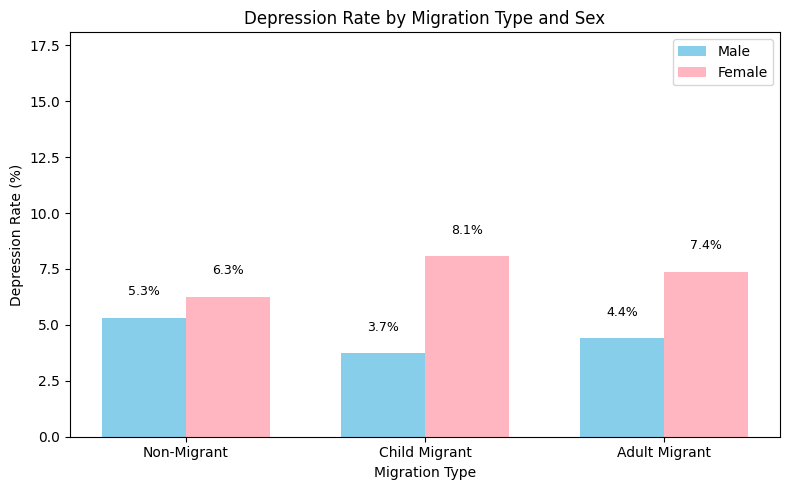

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter for string-based migration types
df_filtered = df_input[df_input["migration_1"].isin(['0', '1', '2'])]

# Depression rate by migration type and sex
grouped = df_filtered.groupby(["migration_1", "sex"])["depression"].mean().unstack() * 100

# Map migration codes to readable labels
migration_labels = {
    '0': "Non-Migrant",
    '1': "Child Migrant",
    '2': "Adult Migrant"
}
grouped.index = grouped.index.map(migration_labels)

# Plotting setup
bar_width = 0.35
x = np.arange(len(grouped.index))  # positions for bars

fig, ax = plt.subplots(figsize=(8, 5))

# Bars for male and female
bars1 = ax.bar(x - bar_width/2, grouped["Male"], width=bar_width, label="Male", color='skyblue')
bars2 = ax.bar(x + bar_width/2, grouped["Female"], width=bar_width, label="Female", color='lightpink')

# Labels and titles
ax.set_xlabel("Migration Type")
ax.set_ylabel("Depression Rate (%)")
ax.set_title("Depression Rate by Migration Type and Sex")
ax.set_xticks(x)
ax.set_xticklabels(grouped.index)
ax.set_ylim(0, max(grouped.max()) + 10)
ax.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


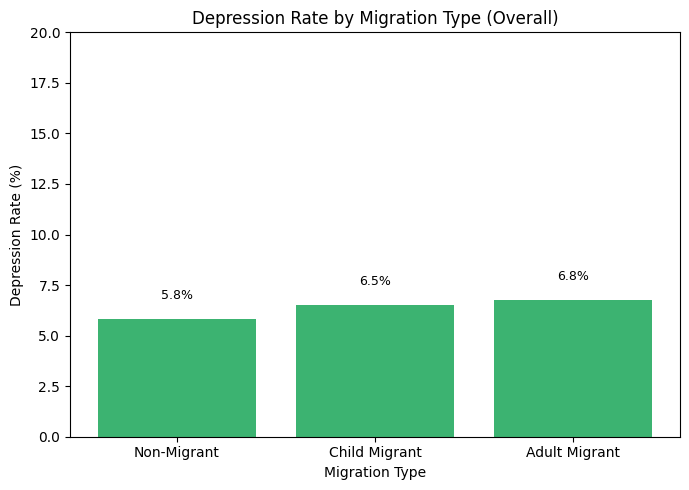

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter only migration_1 in ['0', '1', '2']
df_filtered = df_input[df_input["migration_1"].isin(['0', '1', '2'])]

# Compute depression rate per migration_1 category (overall)
depression_rates = df_filtered.groupby("migration_1")["depression"].mean() * 100

# Map migration codes to readable labels
migration_labels = {
    '0': "Non-Migrant",
    '1': "Child Migrant",
    '2': "Adult Migrant"
}
depression_rates.index = depression_rates.index.map(migration_labels)

# Plot
plt.figure(figsize=(7, 5))
bars = plt.bar(depression_rates.index, depression_rates.values, color='mediumseagreen')

# Labels and title
plt.xlabel("Migration Type")
plt.ylabel("Depression Rate (%)")
plt.title("Depression Rate by Migration Type (Overall)")
plt.ylim(0, max(depression_rates.max(), 10) + 10)

# Add percentage labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


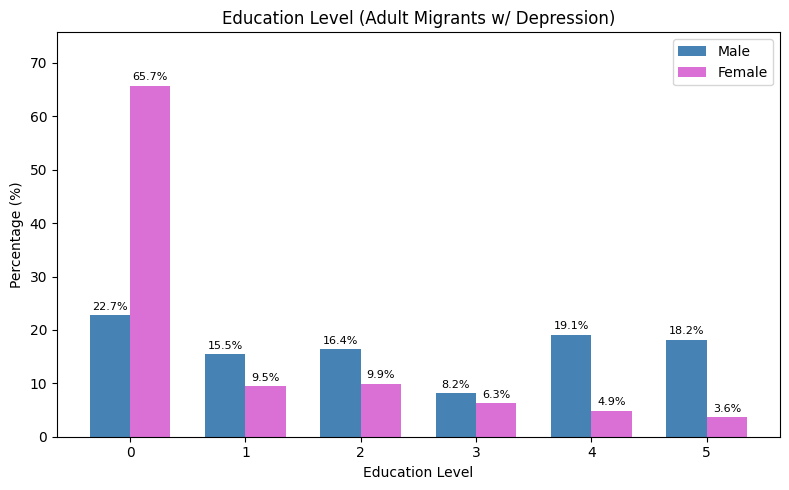

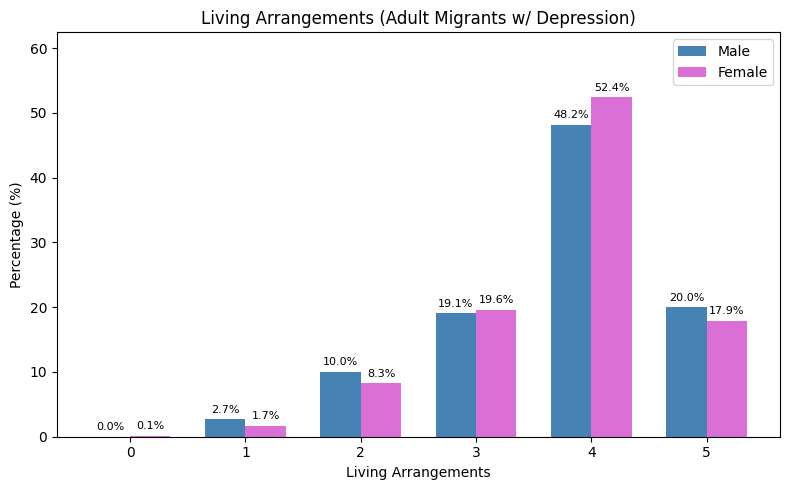

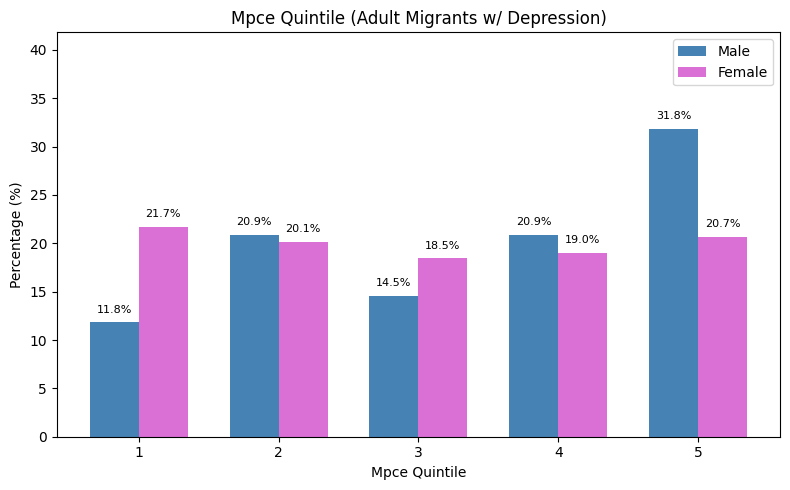

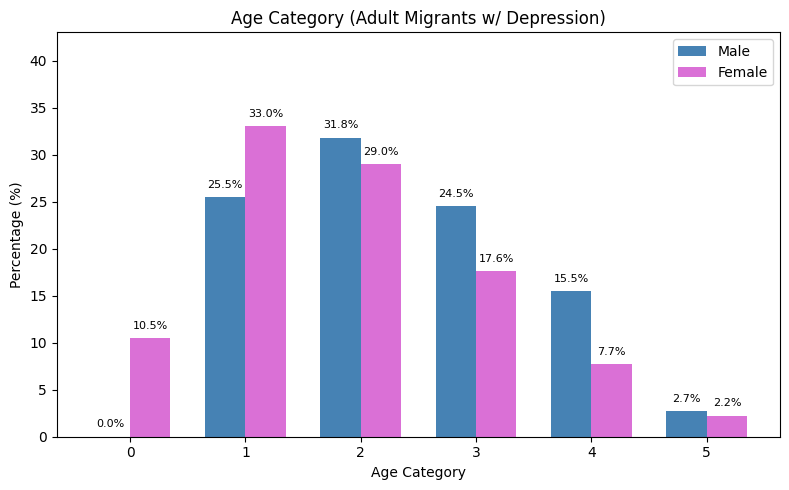

In [16]:
import matplotlib.pyplot as plt

# Filter adult migrants with depression
df_adult_migrants = df_input[(df_input["migration_1"] == '2') & (df_input["depression"] == 1)]

# Features to compare by sex
features = ["education_level", "living_arrangements", "mpce_quintile", "age_category"]

# Labels for comparison
sexes = ["Male", "Female"]
colors = ["steelblue", "orchid"]

def plot_percentage_by_sex(feature):
    # Split data by sex
    male = df_adult_migrants[df_adult_migrants["sex"] == "Male"]
    female = df_adult_migrants[df_adult_migrants["sex"] == "Female"]

    # Get normalized counts (percentages)
    male_pct = male[feature].value_counts(normalize=True).sort_index() * 100
    female_pct = female[feature].value_counts(normalize=True).sort_index() * 100

    # Combine all possible categories
    categories = sorted(set(male_pct.index).union(set(female_pct.index)))

    # Align values with all categories
    male_pct = male_pct.reindex(categories, fill_value=0)
    female_pct = female_pct.reindex(categories, fill_value=0)

    x = range(len(categories))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar([i - width/2 for i in x], male_pct.values, width=width, label="Male", color=colors[0])
    plt.bar([i + width/2 for i in x], female_pct.values, width=width, label="Female", color=colors[1])

    # Labels & title
    plt.xticks(x, [str(c) for c in categories])
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel("Percentage (%)")
    plt.title(f"{feature.replace('_', ' ').title()} (Adult Migrants w/ Depression)")
    plt.legend()

    # Annotate
    for i in x:
        plt.text(i - width/2, male_pct.iloc[i] + 1, f"{male_pct.iloc[i]:.1f}%", ha='center', fontsize=8)
        plt.text(i + width/2, female_pct.iloc[i] + 1, f"{female_pct.iloc[i]:.1f}%", ha='center', fontsize=8)

    plt.ylim(0, max(male_pct.max(), female_pct.max()) + 10)
    plt.tight_layout()
    plt.show()

# Run for all selected features
for feature in features:
    plot_percentage_by_sex(feature)


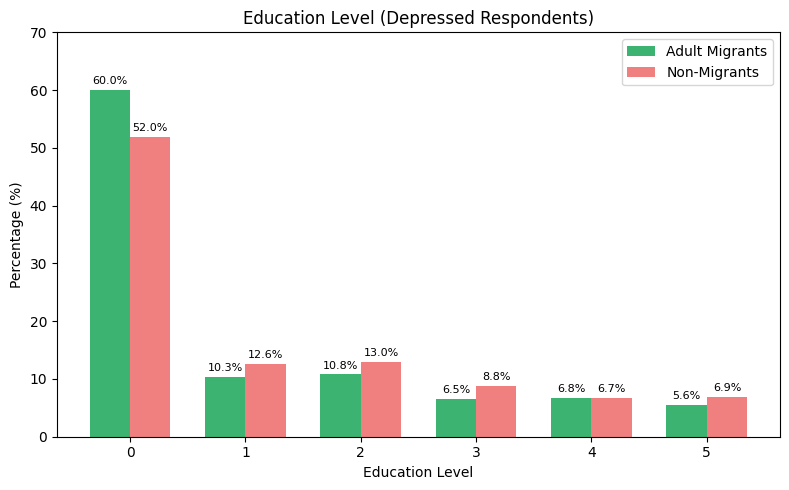

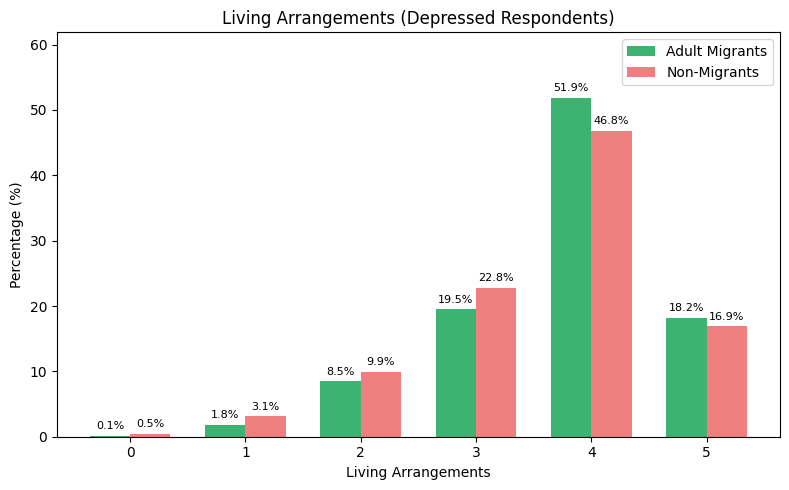

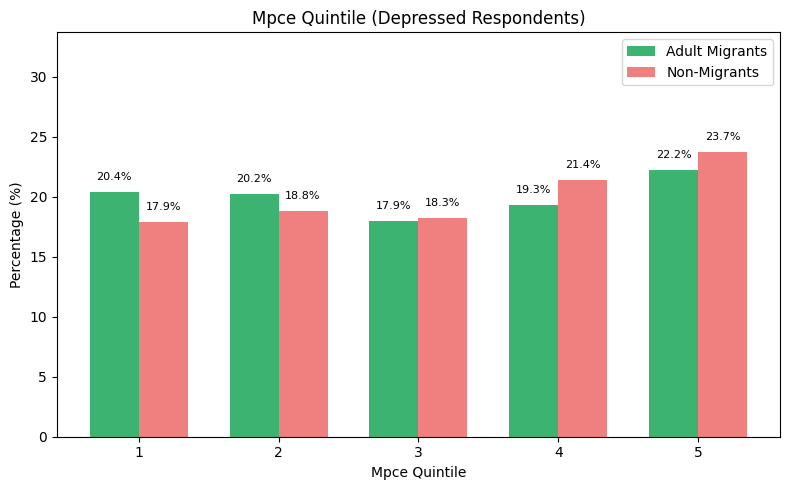

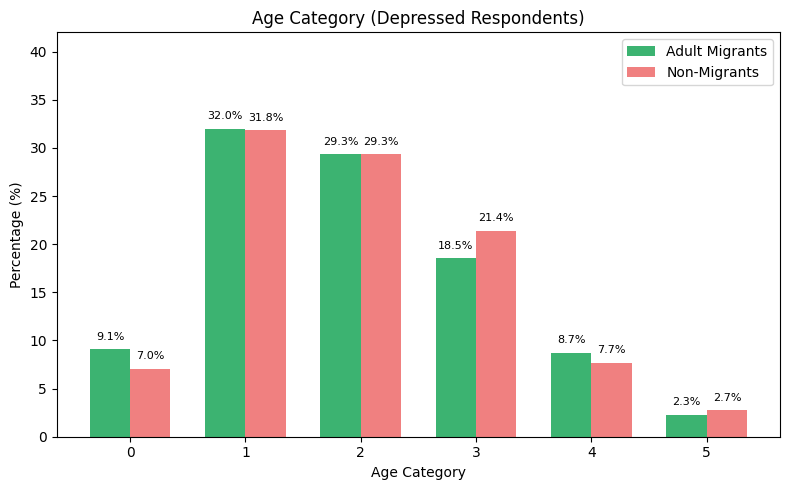

In [19]:
import matplotlib.pyplot as plt

# Filter only respondents with depression
df_depressed = df_input[df_input["depression"] == 1]

# Split into Adult Migrants and Non-Migrants
adult_migrants = df_depressed[df_depressed["migration_1"] == '2']
non_migrants = df_depressed[df_depressed["migration_1"] == '0']

# Features to plot
features = ["education_level", "living_arrangements", "mpce_quintile", "age_category"]
groups = ["Adult Migrants", "Non-Migrants"]
colors = ["mediumseagreen", "lightcoral"]

def plot_percentage_by_group(feature):
    # Calculate percentages per category
    mig_pct = adult_migrants[feature].value_counts(normalize=True).sort_index() * 100
    nonmig_pct = non_migrants[feature].value_counts(normalize=True).sort_index() * 100

    # Combine all categories
    categories = sorted(set(mig_pct.index).union(set(nonmig_pct.index)))
    mig_pct = mig_pct.reindex(categories, fill_value=0)
    nonmig_pct = nonmig_pct.reindex(categories, fill_value=0)

    x = range(len(categories))
    width = 0.35

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar([i - width/2 for i in x], mig_pct.values, width=width, label="Adult Migrants", color=colors[0])
    plt.bar([i + width/2 for i in x], nonmig_pct.values, width=width, label="Non-Migrants", color=colors[1])

    # Labels
    plt.xticks(x, [str(c) for c in categories])
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel("Percentage (%)")
    plt.title(f"{feature.replace('_', ' ').title()} (Depressed Respondents)")
    plt.legend()

    # Annotations
    for i in x:
        plt.text(i - width/2, mig_pct.iloc[i] + 1, f"{mig_pct.iloc[i]:.1f}%", ha='center', fontsize=8)
        plt.text(i + width/2, nonmig_pct.iloc[i] + 1, f"{nonmig_pct.iloc[i]:.1f}%", ha='center', fontsize=8)

    plt.ylim(0, max(mig_pct.max(), nonmig_pct.max()) + 10)
    plt.tight_layout()
    plt.show()

# Run for all features
for feature in features:
    plot_percentage_by_group(feature)


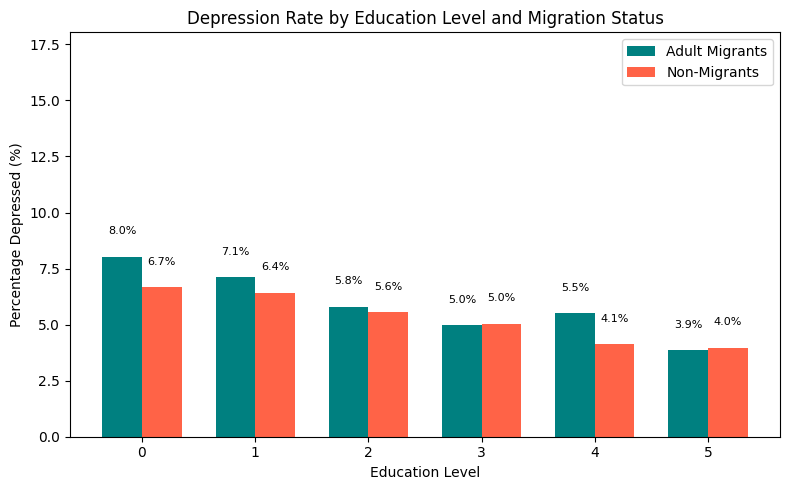

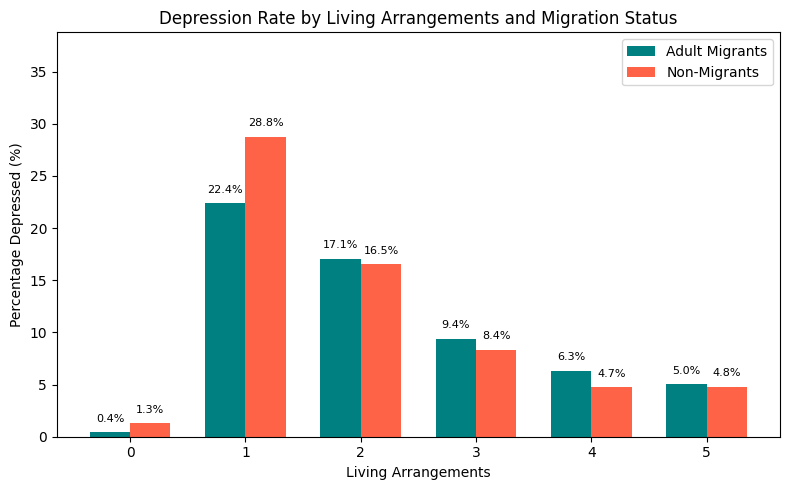

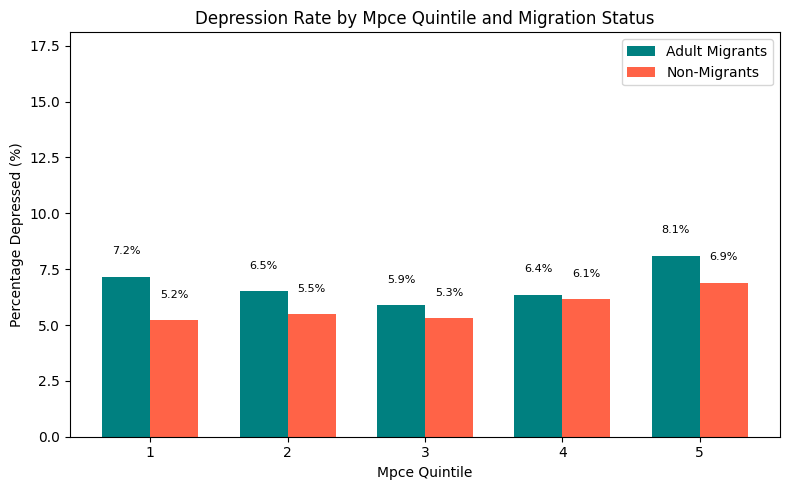

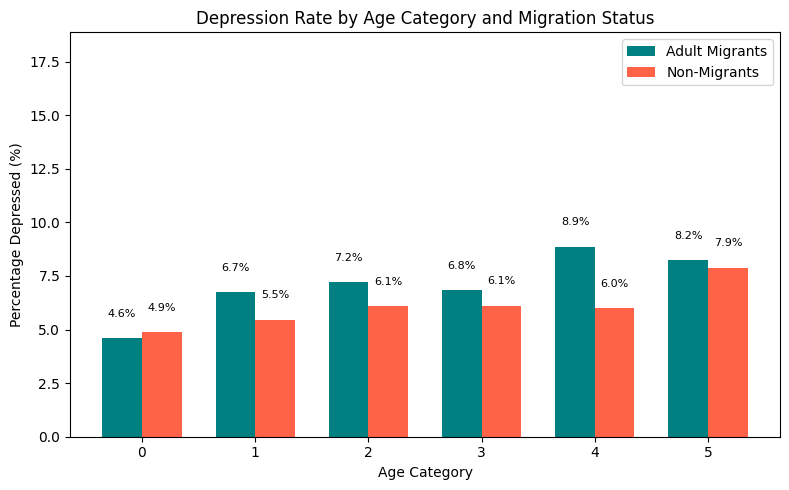

In [22]:
import matplotlib.pyplot as plt

# Define the features to analyze
features = ["education_level", "living_arrangements", "mpce_quintile", "age_category"]

# Filter relevant groups
migrants = df_input[df_input["migration_1"] == '2']
non_migrants = df_input[df_input["migration_1"] == '0']

# Colors and labels
colors = ["teal", "tomato"]
labels = ["Adult Migrants", "Non-Migrants"]

def plot_depression_comparison(feature):
    # Get unique sorted category values from both groups
    categories = sorted(set(migrants[feature].dropna().unique()).union(non_migrants[feature].dropna().unique()))

    # Calculate % depressed in each class
    migrant_pct = migrants.groupby(feature)["depression"].mean().reindex(categories, fill_value=0) * 100
    nonmigrant_pct = non_migrants.groupby(feature)["depression"].mean().reindex(categories, fill_value=0) * 100

    x = range(len(categories))
    width = 0.35

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.bar([i - width/2 for i in x], migrant_pct.values, width=width, label=labels[0], color=colors[0])
    plt.bar([i + width/2 for i in x], nonmigrant_pct.values, width=width, label=labels[1], color=colors[1])

    # Axis and labels
    plt.xticks(x, [str(c) for c in categories])
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel("Percentage Depressed (%)")
    plt.title(f"Depression Rate by {feature.replace('_', ' ').title()} and Migration Status")
    plt.legend()

    # Annotate bars
    for i in x:
        plt.text(i - width/2, migrant_pct.iloc[i] + 1, f"{migrant_pct.iloc[i]:.1f}%", ha='center', fontsize=8)
        plt.text(i + width/2, nonmigrant_pct.iloc[i] + 1, f"{nonmigrant_pct.iloc[i]:.1f}%", ha='center', fontsize=8)

    plt.ylim(0, max(migrant_pct.max(), nonmigrant_pct.max()) + 10)
    plt.tight_layout()
    plt.show()

# Run the plots
for feature in features:
    plot_depression_comparison(feature)


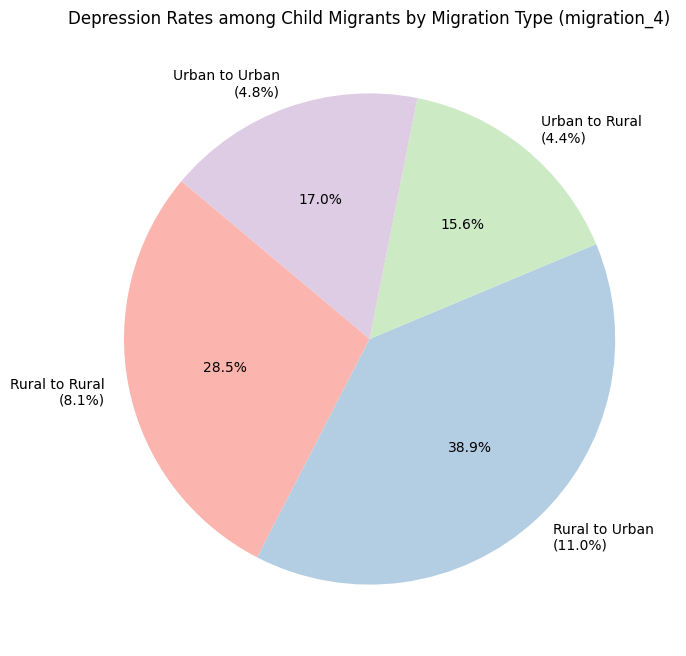

In [25]:
import matplotlib.pyplot as plt

# Filter for child migrants only (migration_1 == '1')
df_child_migrants = df_input[df_input["migration_1"] == '1']

# Labels for migration_4 types
migration_4_labels = {
    1: "Rural to Rural",
    2: "Rural to Urban",
    3: "Urban to Rural",
    4: "Urban to Urban"
}

# Prepare data for pie chart
depression_rates = {}
for m_type in [1, 2, 3, 4]:
    group = df_child_migrants[df_child_migrants["migration_4"] == m_type]
    if len(group) == 0:
        continue  # skip if no data in group
    depressed_pct = group["depression"].mean() * 100
    depression_rates[migration_4_labels[m_type]] = depressed_pct

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    depression_rates.values(),
    labels=[f"{k}\n({v:.1f}%)" for k, v in depression_rates.items()],
    autopct="%1.1f%%",
    startangle=140,
    colors=plt.cm.Pastel1.colors
)

plt.title("Depression Rates among Child Migrants by Migration Type (migration_4)")
plt.tight_layout()
plt.show()


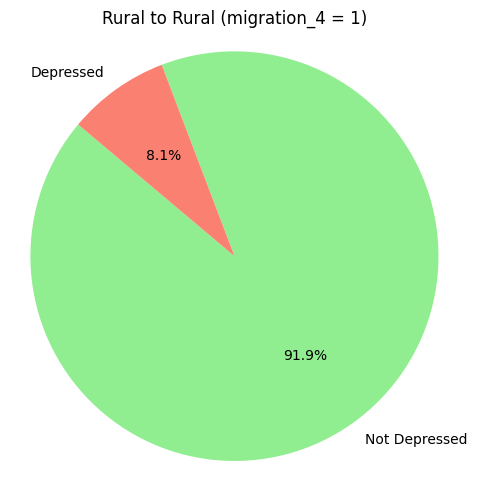

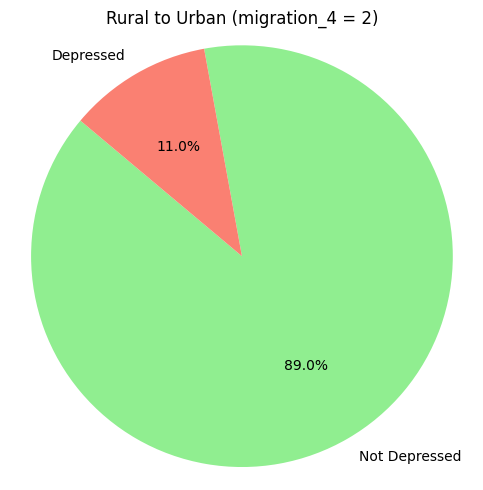

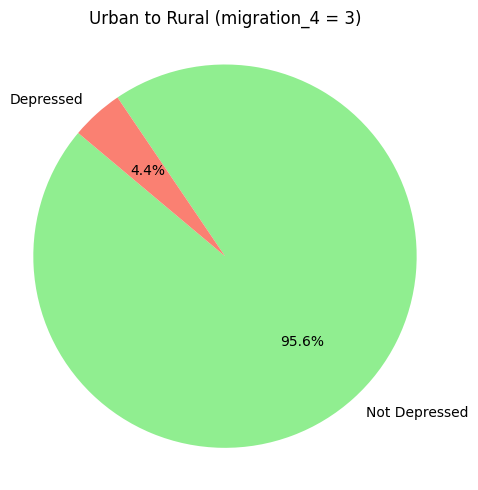

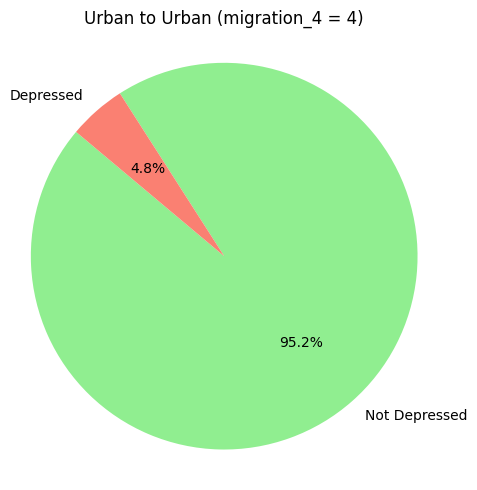

In [26]:
import matplotlib.pyplot as plt

# Filter for childhood migrants only
child_migrants = df_input[df_input["migration_1"] == '1']

# Mapping for migration_4 labels
migration_4_labels = {
    1: "Rural to Rural",
    2: "Rural to Urban",
    3: "Urban to Rural",
    4: "Urban to Urban"
}

# Loop through each migration_4 group and plot pie chart
for mig_type in [1, 2, 3, 4]:
    group = child_migrants[child_migrants["migration_4"] == mig_type]

    if group.empty:
        print(f"No data for migration_4 = {mig_type}")
        continue

    # Count depressed vs not depressed
    counts = group["depression"].value_counts().reindex([0, 1], fill_value=0)
    labels = ["Not Depressed", "Depressed"]
    colors = ["lightgreen", "salmon"]

    # Plot pie chart
    plt.figure(figsize=(5, 5))
    plt.pie(counts, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140)
    plt.title(f"{migration_4_labels[mig_type]} (migration_4 = {mig_type})")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


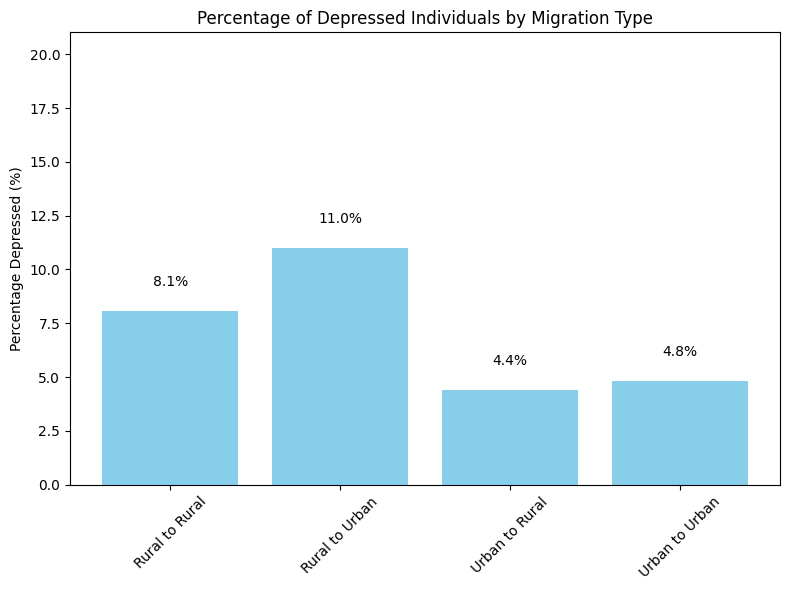

In [34]:
import matplotlib.pyplot as plt

# Filter for childhood migrants only
child_migrants = df_input[df_input["migration_1"] == '1']

# Migration types mapping
migration_4_labels = {
    1: "Rural to Rural",
    2: "Rural to Urban",
    3: "Urban to Rural",
    4: "Urban to Urban"
}

# Prepare data
depressed_percentages = []
x_labels = []

for mig_type in [1, 2, 3, 4]:
    group = child_migrants[child_migrants["migration_4"] == mig_type]
    if group.empty:
        print(f"No data for migration_4 = {mig_type}")
        continue

    total = len(group)
    depressed = group["depression"].value_counts().get(1, 0)
    percent_depressed = (depressed / total) * 100

    depressed_percentages.append(percent_depressed)
    x_labels.append(migration_4_labels[mig_type])

# Plot bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(x_labels, depressed_percentages, color='skyblue')

# Annotate bars with percentages
for bar, percent in zip(bars, depressed_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f"{percent:.1f}%", ha='center', va='bottom', fontsize=10)

plt.ylabel("Percentage Depressed (%)")
plt.title("Percentage of Depressed Individuals by Migration Type")
plt.ylim(0, max(depressed_percentages) + 10)  # add space for labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


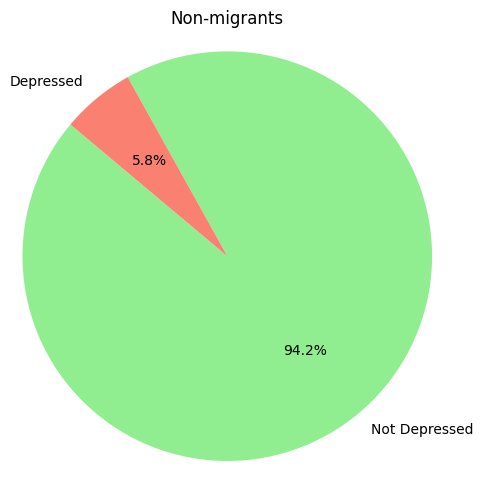

In [30]:
import matplotlib.pyplot as plt

# Filter for childhood migrants only
child_migrants = df_input[df_input["migration_1"] == '0']



# Loop through each migration_4 group and plot pie chart

group = child_migrants

if group.empty:
    print(f"No data")
else:

# Count depressed vs not depressed
    counts = group["depression"].value_counts().reindex([0, 1], fill_value=0)
    labels = ["Not Depressed", "Depressed"]
    colors = ["lightgreen", "salmon"]

    # Plot pie chart
    plt.figure(figsize=(5, 5))
    plt.pie(counts, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140)
    plt.title(f"Non-migrants")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

def one_hot_encode(df, column):
    dummies = pd.get_dummies(df[column], prefix=column).astype(int)
    dummies.columns = [f"{column}_{i+1}" for i in range(dummies.shape[1])]

    for col in dummies.columns:
        df[col] = dummies[col]

df_fp3['migration_2'] = df_input['migration_2']

binary_features = ['migration_2']
numerical_features = ['dm005']
ordinal_features = ['dm008', 'mpce_quintile']
categorial_cols = ['fs318']
categorial_features = []

for col in categorial_cols:
    one_hot_encode(df_fp3, col)
    for i in range(df_fp3[col].nunique()):
        categorial_features.append(col + f'_{i+1}')

feature_cols = binary_features + numerical_features + ordinal_features + categorial_features
X = df_fp3[feature_cols]

# Handle missing values
imputer_mode = SimpleImputer(strategy='most_frequent')
X[binary_features + ordinal_features + categorial_features] = imputer_mode.fit_transform(X[binary_features + ordinal_features + categorial_features])

imputer_mean = SimpleImputer(strategy='mean')
X[numerical_features] = imputer_mean.fit_transform(X[numerical_features])

print(len(X))

# Add intercept (constant column)
X.insert(0, 'const', 1)

# Check for NaN and remove if any
X.dropna(inplace=True)

print(len(X))

# Compute VIF (Variance Inflation Factor)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)
print("-----------------------------------------------------------------")

for col in X.columns:
    print("col: ", X[col].value_counts())

# Fit logistic regression model using Scikit-Learn
y = df_input['depression']

model = LogisticRegression(max_iter=1000)  # Increase max_iter to ensure convergence
model.fit(X, y)

# Get adjusted odds ratio
adjusted_or = np.exp(model.coef_[0][1])  # Exp of coefficient for migration_2
print("Adjusted odds ratio: ", adjusted_or)

# Compute unadjusted odds ratio manually
odds_migration = np.sum((df_input['migration_2'] == 1) & (df_input['depression'] == 1)) / np.sum((df_input['migration_2'] == 1) & (df_input['depression'] == 0))
odds_not_migration = np.sum((df_input['migration_2'] == 0) & (df_input['depression'] == 1)) / np.sum((df_input['migration_2'] == 0) & (df_input['depression'] == 0))
print("Unadjusted odds ratio: ", odds_migration / odds_not_migration)


C:\Users\91981\AppData\Local\Temp\ipykernel_17476\641131082.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[binary_features + ordinal_features + categorial_features] = imputer_mode.fit_transform(X[binary_features + ordinal_features + categorial_features])
C:\Users\91981\AppData\Local\Temp\ipykernel_17476\641131082.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_features] = imputer_mean.fit_transform(X[numerical_features])
C:\Users\91981\AppData\Local\Temp\ipykernel_17476\641131082.py

73396
73396
        Variable        VIF
0          const  41.320692
1    migration_2   1.038628
2          dm005   1.221055
3          dm008   1.076530
4  mpce_quintile   1.053917
5        fs318_1   1.020288
6        fs318_2   1.086224
7        fs318_3   1.149700
8        fs318_4   1.000389
9        fs318_5   1.002046
-----------------------------------------------------------------
col:  const
1    73396
Name: count, dtype: int64
col:  migration_2
0.0    65063
1.0     8333
Name: count, dtype: int64
col:  dm005
45.0     3231
65.0     3180
60.0     3166
50.0     3143
55.0     2929
         ... 
108.0       1
103.0       1
18.0        1
116.0       1
111.0       1
Name: count, Length: 93, dtype: int64
col:  dm008
2.0    43611
1.0     8188
3.0     7345
4.0     6800
5.0     3300
7.0     2513
8.0      758
9.0      540
6.0      341
Name: count, dtype: int64
col:  mpce_quintile
4.0    14908
3.0    14764
2.0    14757
5.0    14545
1.0    14422
Name: count, dtype: int64
col:  fs318_1
0.0    7220

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def compute_adjusted_odds_ratios(df, migration_col, outcome_col, confounders, non_migrant_value):
    results = []

    # Get unique migration categories excluding non-migrants
    migration_classes = df[migration_col].unique()
    migration_classes = [cat for cat in migration_classes if cat != non_migrant_value]

    for category in migration_classes:
        # Filter data: Keep only current migration category and non-migrants
        sub_df = df[df[migration_col].isin([category, non_migrant_value])].copy()

        # Check if confounders exist in the filtered sub_df
        valid_confounders = [col for col in confounders if col in sub_df.columns]

        # Convert migration column into binary (1 = current category, 0 = non-migrant)
        sub_df[migration_col] = (sub_df[migration_col] == category).astype(int)

        # Define independent (X) and dependent (y) variables
        y = sub_df[outcome_col]  # Binary outcome
        X = sub_df[[migration_col] + valid_confounders]  # Select features

        # Handle NaN values:
        # - Fill confounders' NaN values with mean
        print(X[migration_col].nunique())


        for col in valid_confounders:
            X[col] = X[col].fillna(X[col].mean())

        # - Fill NaN values in migration_col and outcome_col with mode
        X[migration_col] = X[migration_col].fillna(X[migration_col].mode()[0])
        y = y.fillna(y.mode()[0])

        # Add constant for logistic regression
        X = sm.add_constant(X)

        # Ensure there are no all-zero or all-one columns (to avoid singular matrix issues)
        if X[migration_col].nunique() < 2 or y.nunique() < 2:
            print(f"Skipping category {category}: Not enough variation in data.")
            print("X[migration_col].nunique(): ",X[migration_col].nunique())
            print("y.nunique() ",y.nunique())
            continue

        # Fit logistic regression model
        model = sm.Logit(y, X).fit(disp=0)  # Suppress output

        # Extract odds ratio and p-value for migration category
        or_value = np.exp(model.params[migration_col])  # Adjusted OR
        p_value = model.pvalues[migration_col]  # P-value

        # Store results
        results.append({'Migration Category': category, 'Adjusted OR': round(or_value, 3), 'p-value': round(p_value, 3)})

    # Convert results to a DataFrame
    return pd.DataFrame(results)


In [38]:
compute_adjusted_odds_ratios(df_input, 'migration_1', 'depression', ['dm005'], '0')
compute_adjusted_odds_ratios(df_input, 'migration_2', 'depression', ['dm005'], '0')
compute_adjusted_odds_ratios(df_input, 'migration_3', 'depression', ['dm005'], '0')
compute_adjusted_odds_ratios(df_input, 'migration_4', 'depression',['dm005'],'0')

2
2
1
Skipping category 0: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping category 1: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping category 6: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2


C:\Users\91981\AppData\Local\Temp\ipykernel_17476\4050336641.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[migration_col] = X[migration_col].fillna(X[migration_col].mode()[0])
C:\Users\91981\AppData\Local\Temp\ipykernel_17476\4050336641.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[migration_col] = X[migration_col].fillna(X[migration_col].mode()[0])
C:\Users\91981\AppData\Local\Temp\ipykernel_17476\4050336641.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

1
Skipping category 5: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping category 4: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping category 1: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping category 3: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping category 2: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping category 0: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping category 0: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping category 1: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping category 2: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping category 4: Not enough variation in data.
X[migration_col].nunique():  1
y.nunique()  2
1
Skipping

C:\Users\91981\AppData\Local\Temp\ipykernel_17476\4050336641.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[migration_col] = X[migration_col].fillna(X[migration_col].mode()[0])
C:\Users\91981\AppData\Local\Temp\ipykernel_17476\4050336641.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[migration_col] = X[migration_col].fillna(X[migration_col].mode()[0])
C:\Users\91981\AppData\Local\Temp\ipykernel_17476\4050336641.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

""


# Documentation for Geetika, Siddharth, Vaishnavi

| **Variable**           | **Type**        | **Code / Description**                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | **Dependent/Independent** |
|------------------------|-----------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------|
| **migration_1**        | Categorical     | **Life‐course migration indicator** <br>• **0**: No migration <br>• **1**: Childhood migration <br>• **2**: Adult migration                                                                                                                                                                                                                                                                                                                                                         | Independent                |
| **migration_2**        | Binary          | **Hard threshold indicator based on duration of residence:**<br>• **1**: Migrant (respondent has lived continuously in the current area for less than 20 (THRESHOLD) years).<br>• **0**: Non‐migrant (respondent has lived 20 (THRESHOLD) years or more in the current area).                                                                                                                                                                                                                                              | Independent                |
| **migration_3**        | Ordinal         | **Duration‐based migration indicator** (using “Since how many years living continuously in this area”):<br>• **1**: 0–2 years<br>• **2**: 3–5 years<br>• **3**: 6–10 years<br>• **4**: 11–20 years<br>• **5**: 21–40 years<br>• **6**: More than 40 years                                                                                                                                                                                                                                                                    | Independent                |
| **migration_4**        | Categorical     | **Rural/Urban migration type** (based on rural/urban codes for “Place of Birth” and “Place of Last Residence”):<br>• **1**: Rural-to-Rural<br>• **2**: Rural-to-Urban<br>• **3**: Urban-to-Rural<br>• **4**: Urban-to-Urban<br>• **0**: Missing/undefined (if either location is missing)                                                                                                                                                                                                                                  | Independent                |
| **CIDI_1**             | Numeric (Score) | **Depression score from CIDI-SF (Part 1):** Sum of “Yes” responses to items MH204–MH211.                                                                                                                                                                                                                                                                                                                                                                                           | Ignore this                |
| **CIDI_2**             | Numeric (Score) | **Depression score from CIDI-SF (Part 2):** Sum of “Yes” responses to items MH217–MH222. This score is used as a complementary measure of depression.                                                                                                                                                                                                                                                                                                                             | Ignore this                |
| **Depression**         | Binary          | **Depression outcome variable:**<br>• **1**: The respondent is considered at risk for depression (CIDI_1 score ≥ 3).<br>• **0**: Otherwise.                                                                                                                                                                                                                                                                                                                                         | Dependent                |
| **education**          | Ordinal         | **Educational attainment** (derived from DM008, with DM006 “Ever attended school” check):<br>• **0**: Did not attend school or DM006 ≠ 1<br>• **1**: Less than primary school (Standard 1–4)<br>• **2**: Primary school completed (Standard 5–7)<br>• **3**: Middle school completed (Standard 8–9)<br>• **4**: Secondary/Matriculation completed<br>• **5**: Higher secondary/Intermediate and above (Diploma, Graduate, Postgraduate, or Professional course)                | Independent and Controlling Variable                |
| **living_arrangements**| Ordinal         | **Satisfaction with current living arrangements** (from FS329):<br>• **1**: Strongly dissatisfied<br>• **2**: Dissatisfied<br>• **3**: Neither satisfied nor dissatisfied<br>• **4**: Satisfied<br>• **5**: Strongly satisfied                                                                                                                                                                                                                                                        | Independent and Controlling Variable                |
| **mpce_quintile**      | Ordinal         | **Monthly Per Capita Consumption Expenditure (MPCE) Quintile**:<br>• **1**: Lowest quintile<br>• **2**: Second quintile<br>• **3**: Middle quintile<br>• **4**: Fourth quintile<br>• **5**: Highest quintile                                                                                                                                                                                                                                                                         | Independent and Controlling Variable                |
| **age_category**       | Ordinal         | **Age group** (derived from “Age at last birthday”):<br>• **1**: 45–55 years<br>• **2**: 55–65 years<br>• **3**: 65–75 years<br>• **4**: 75–85 years<br>• **5**: Over 85 years                                                                                                                                                                                                                                                                                                       | Independent and Controlling Variable                |

---


# Full Documentation

| **Variable**           | **Type**        | **Code / Description**                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | **Dependent/Independent** |
|------------------------|-----------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------|
| **migration_1**        | Categorical     | **Life‐course migration indicator** (derived using “Since how many years living continuously in this area” plus life‐course residence data):<br>• **0**: No migration – either the respondent has lived in the same location throughout life or the “years living” answer is coded as 9993 (“since birth”).<br>• **1**: Childhood migration – if any component (country, state, district, or village/town) of the childhood residence differs from the corresponding component of the place of birth.<br>• **2**: Adult migration – if no childhood migration is detected but any component of the adult residence differs from the corresponding component of the place of birth. | Independent |
| **migration_2**        | Binary          | **Hard threshold indicator based on duration of residence:**<br>• **1**: Migrant (respondent has lived continuously in the current area for less than 20 years).<br>• **0**: Non‐migrant (respondent has lived 20 years or more in the current area).                                                                                                                                                                                                                                                        | Independent |
| **migration_3**        | Ordinal         | **Duration‐based migration indicator** (using “Since how many years living continuously in this area”):<br>• **1**: 0–2 years<br>• **2**: 3–5 years<br>• **3**: 6–10 years<br>• **4**: 11–20 years<br>• **5**: 21–40 years<br>• **6**: More than 40 years                                                                                                                                                                                                                                  | Independent |
| **migration_4**        | Categorical     | **Rural/Urban migration type** (based on rural/urban codes for “Place of Birth” and “Place of Last Residence”):<br>• **1**: Rural-to-Rural<br>• **2**: Rural-to-Urban<br>• **3**: Urban-to-Rural<br>• **4**: Urban-to-Urban<br>• **0**: Missing/undefined (if either location is missing)                                                                                                                                                                                                                           | Independent |
| **CIDI_1**             | Numeric (Score) | **Depression score from CIDI-SF (Part 1):** Sum of “Yes” responses to items MH204–MH211. A score of 3 or higher indicates risk of depression.                                                                                                                                                                                                                                                                                                                                       | Ignore this |
| **CIDI_2**             | Numeric (Score) | **Depression score from CIDI-SF (Part 2):** Sum of “Yes” responses to items MH217–MH222. This score is used as a complementary measure of depression.                                                                                                                                                                                                                                                                                                                               | Ignore this |
| **Depression**         | Binary          | **Depression outcome variable:**<br>• **1**: The respondent is considered at risk for depression (CIDI-SF score ≥ 3).<br>• **0**: Otherwise.                                                                                                                                                                                                                                                                                                                                        | Dependent |
| **education**          | Ordinal         | **Educational attainment** (derived from DM008, with DM006 “Ever attended school” check):<br>• **0**: Did not attend school or DM006 ≠ 1<br>• **1**: Less than primary school (Standard 1–4)<br>• **2**: Primary school completed (Standard 5–7)<br>• **3**: Middle school completed (Standard 8–9)<br>• **4**: Secondary/Matriculation completed<br>• **5**: Higher secondary/Intermediate and above (Diploma, Graduate, Postgraduate, or Professional course)                            | Independent and Controlling Variable |
| **living_arrangements**| Ordinal         | **Satisfaction with current living arrangements** (from FS329):<br>• **1**: Strongly dissatisfied<br>• **2**: Dissatisfied<br>• **3**: Neither satisfied nor dissatisfied<br>• **4**: Satisfied<br>• **5**: Strongly satisfied                                                                                                                                                                                                                                                        | Independent and Controlling Variable |
| **mpce_quintile**      | Ordinal         | **Monthly Per Capita Consumption Expenditure (MPCE) Quintile**:<br>• **1**: Lowest quintile<br>• **2**: Second quintile<br>• **3**: Middle quintile<br>• **4**: Fourth quintile<br>• **5**: Highest quintile                                                                                                                                                                                                                                                                         | Independent and Controlling Variable |
| **age_category**       | Ordinal         | **Age group** (derived from “Age at last birthday”):<br>• **1**: 45–55 years<br>• **2**: 55–65 years<br>• **3**: 65–75 years<br>• **4**: 75–85 years<br>• **5**: Over 85 years                                                                                                                                                                                                                                                                                                         | Independent and Controlling Variable |


